In [5]:
from numpy import array
import keras
from keras.utils import plot_model
import pydot
from tensorflow.keras import backend as K
import keras.backend.common
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [6]:
filename='nlp_train.json'
import json

with open(filename) as f:
    data = json.load(f)



Enter you file Name:kk


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
k_dict={}
for key in data:
    a={}
    a[data[key]['body']]=data[key]['emotion']
    k_dict[key]=a
with open('ready.json', 'w') as json_file:
    json.dump(k_dict, json_file)

In [8]:
import csv
inputFile = open('ready.json')
outputFile = open('final.csv', 'w')
data = json.load(inputFile)
inputFile.close() 
output = csv.writer(outputFile)
final_list=[]


def preprocess_text(sen):
   
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

   
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

   
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

output.writerow(["id","body","anger","anticipation","disgust","fear","joy","love","optimism","pessimism","sadness","surprise","trust","neutral"])
for value,key in enumerate(data):
    a=[]
    #a.append(key)
    #a.append(data[key].keys()[0])
    a.append(key)
    for body in data[key].keys():
        a.append(preprocess_text(body))
        for emotion in data[key][body]:
            e=data[key][body][emotion]
            if e:
                a.append(1)
            else:
                a.append(0)
    output.writerow(a)

In [9]:
file = pd.read_csv("final.csv")
file

,id,body,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,fkrr36o,He was answering question about the criticism ...,1,0,1,0,0,0,0,1,0,0,0,0
1,fjyfp0o,I going to start today discussion thread with ...,1,1,1,1,0,0,0,1,0,0,0,0
2,fibm0x7,By announcing the self quarantined it paints p...,1,1,1,1,0,0,0,1,0,0,0,0
3,fj9b4oj,Likewise sorry if offended you m not actually ...,1,0,1,1,0,0,0,1,0,0,0,0
4,fk04ri5,People infected by experience high fever cough...,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,fk6dgi5,LAUSD Superintendent Beutner gets additional c...,0,0,0,0,0,0,0,0,0,0,0,1
1486,fkehkor,The article for those who run into pay wall am...,0,1,0,1,0,0,1,1,0,0,0,0
1487,fipueyz,At least as for this case in Hokkaido Northern...,0,0,0,0,0,0,0,0,0,0,0,1
1488,fkedc6p,Yes you are correct rd war countries have it p...,1,0,1,1,0,0,0,1,1,0,0,0


In [10]:
filter = file["body"] != ""
file = file[filter]
file = file.dropna()

In [12]:
file_labels = file[["anger", "anticipation", "disgust", "fear", "joy", "love","optimism","pessimism","sadness","surprise","trust","neutral"]]
file_labels.head()

,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,1,0,1,0,0,0,0,1,0,0,0,0
1,1,1,1,1,0,0,0,1,0,0,0,0
2,1,1,1,1,0,0,0,1,0,0,0,0
3,1,0,1,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1


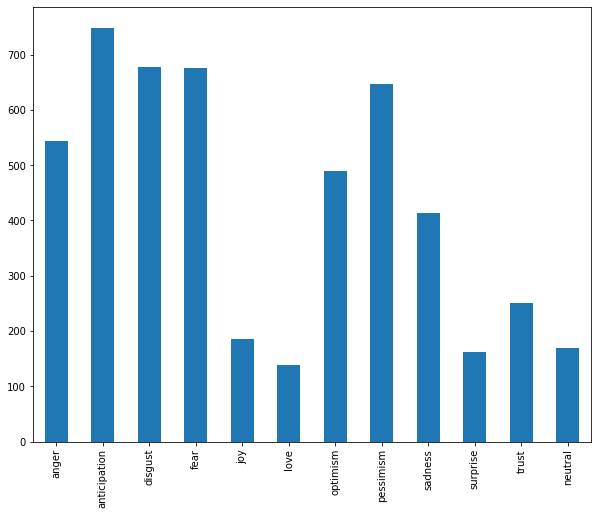

In [13]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

file_labels.sum(axis=0).plot.bar()

In [14]:
X = []
sentences = list(file["body"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = file_labels.values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [17]:
#USING GLOVE 

from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector


In [18]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)

In [19]:
LSTM_Layer_1 = LSTM(128)(embedding_layer)
#LSTM_Layer_2 = LSTM(128,return_state=True, dropout = 0.5)(LSTM_Layer_1)
dense_layer_1 = Dense(12, activation='relu')(LSTM_Layer_1)
dense_layer_2= Dense(12, activation='relu')(dense_layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_2)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])



"""model.add(LSTM(150,
               input_shape=(64, 7, 339),
               return_sequences=False))
model.add(Dropout(0.2))
model.add(LSTM(
    200,
    return_sequences=True))
model.add(Dropout(0.2))"""


'model.add(LSTM(150,\n               input_shape=(64, 7, 339),\n               return_sequences=False))\nmodel.add(Dropout(0.2))\nmodel.add(LSTM(\n    200,\n    return_sequences=True))\nmodel.add(Dropout(0.2))'

In [20]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          2493000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
Total params: 2,611,952
Trainable params: 118,952
Non-trainable params: 2,493,000
_________________________________________________________________
None


In [21]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 953 samples, validate on 239 samples
Epoch 1/20
953/953 [==============================] - 4s 4ms/step - loss: 1.7018 - acc: 0.7060 - val_loss: 1.2061 - val_acc: 0.6806
Epoch 2/20
953/953 [==============================] - 3s 3ms/step - loss: 1.1346 - acc: 0.7142 - val_loss: 1.1639 - val_acc: 0.6998
Epoch 3/20
953/953 [==============================] - 3s 3ms/step - loss: 1.0921 - acc: 0.7252 - val_loss: 1.1108 - val_acc: 0.7054
Epoch 4/20
953/953 [==============================] - 3s 3ms/step - loss: 1.0185 - acc: 0.7305 - val_loss: 1.0228 - val_acc: 0.7092
Epoch 5/20
953/953 [==============================] - 3s 3ms/step - loss: 0.9452 - acc: 0.7224 - val_loss: 0.9596 - val_acc: 0.7085
Epoch 6/20
953/953 [==============================] - 3s 3ms/step - loss: 0.9272 - acc: 0.7198 - val_loss: 0.9503 - val_acc: 0.7141
Epoch 7/20
953/953 [==============================] - 3s 3ms/step -

In [22]:
score=model.evaluate(X_test,y_test,verbose=1)
print(score[0])
print(score[1])

298/298 [==============================] - 1s 2ms/step
0.7981947352422164
0.7321029305458069


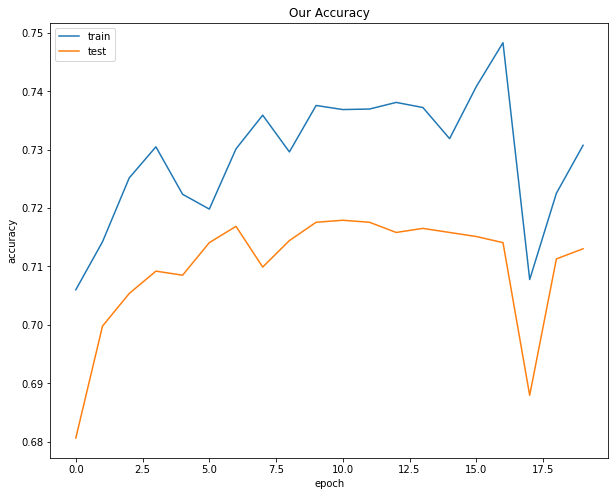

In [23]:
#import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Our Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()
